In [1]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from lmu import LMU

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical

In [2]:
# Set seed to ensure this example is reproducible
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

# load mnist dataset
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.mnist.load_data()

# Change inputs to 0--1 range
train_images = train_images / 255
test_images = test_images / 255

# Flatten images into sequences
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# Apply permutation
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(50000, 784, 1) (50000,)
(10000, 784, 1) (10000,)
(10000, 784, 1) (10000,)


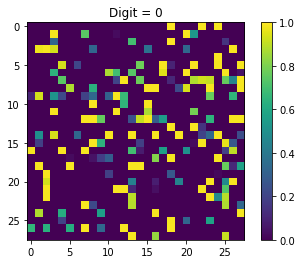

In [3]:
plt.subplot(111)
plt.title("Digit = %d" % Y_train[1])
plt.imshow(X_train[1].reshape(28, 28))
plt.colorbar()
plt.show()

In [4]:
padded_length = 28 ** 2 + 1
n_pixels = padded_length - 1


def lmu_layer(**kwargs):
    return LMU(
        units=212,
        order=256,
        theta=n_pixels,
        memory_to_memory=False,
        hidden_to_memory=False,
        hidden_to_hidden=False,
        input_encoders_initializer=Constant(1),
        hidden_encoders_initializer=Constant(0),
        memory_encoders_initializer=Constant(0),
        input_kernel_initializer=Constant(0),
        hidden_kernel_initializer=Constant(0),
        memory_kernel_initializer="glorot_normal",
        return_sequences=False,
        **kwargs
    )


model = Sequential()
model.add(lmu_layer(input_shape=X_train.shape[1:],))  # (nr. of pixels, 1)
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

FFT layer

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lmu (LMU)                    (None, 212)               54485     
_________________________________________________________________
dense (Dense)                (None, 10)                2130      
Total params: 56,615
Trainable params: 56,615
Non-trainable params: 0
_________________________________________________________________


In [5]:
batch_size = 100
epochs = 10
t = time.time()

fname = "./psMNIST-fft.hdf5"
callbacks = [
    ModelCheckpoint(filepath=fname, monitor="val_loss", verbose=1, save_best_only=True),
]

result = model.fit(
    X_train,
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, to_categorical(Y_valid)),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
49900/50000 [============================>.] - ETA: 0s - loss: 0.5342 - accuracy: 0.8529
Epoch 00001: val_loss improved from inf to 0.31574, saving model to ./psMNIST-fft.hdf5
50000/50000 [==============================] - 36s 712us/sample - loss: 0.5338 - accuracy: 0.8530 - val_loss: 0.3157 - val_accuracy: 0.9116
Epoch 2/10
49900/50000 [============================>.] - ETA: 0s - loss: 0.3339 - accuracy: 0.9045
Epoch 00002: val_loss improved from 0.31574 to 0.28711, saving model to ./psMNIST-fft.hdf5
50000/50000 [==============================] - 36s 715us/sample - loss: 0.3342 - accuracy: 0.9045 - val_loss: 0.2871 - val_accuracy: 0.9193
Epoch 3/10
49900/50000 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.9157
Epoch 00003: val_loss improved from 0.28711 to 0.24447, saving model to ./psMNIST-fft.hdf5
50000/50000 [==============================] - 35s 708us/sample - loss: 0.2889 - accuracy: 0.9156 - v

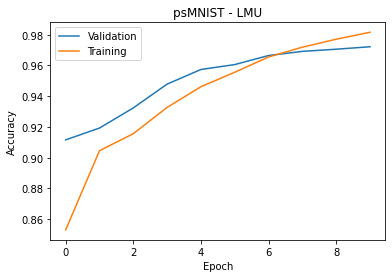

In [6]:
plt.figure()
plt.plot(result.history["val_accuracy"], label="Validation")
plt.plot(result.history["accuracy"], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("psMNIST - LMU")
plt.show()

In [7]:
saved_epoch = np.argmin(result.history["val_loss"])
print(result.history["val_accuracy"][saved_epoch])

0.9722


In [8]:
model.load_weights(fname)  # load best weights

In [9]:
model.evaluate(X_test, to_categorical(Y_test))

10000/10000 [==============================] - 4s 407us/sample - loss: 0.0944 - accuracy: 0.9701


[0.09441915852930396, 0.9701]